## ML Classification
Uses previously obtained number of GM, WM, & CSF pixels to train a logistic-regression classifier to find relationship between GM, WM, CSF and age

### Import Libraries & Pathing

In [35]:
from pathlib import Path
import os
import os.path as op
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# Scikit-learn
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report, make_scorer, balanced_accuracy_score, fbeta_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
nl = '\n' # For f-string formatting

In [36]:
## Pathing
path = '../'

images_path = Path(path, 'data', 'images')
masks_path = Path(path, 'data', 'masks')
segs_path = Path(path, 'data', 'segs_refs')
metadata_path = Path(path, 'data', 'meta')

## Preparing Data for Classification

In [37]:
## Reading in data from CSV file
    # Make sure to run Get "brain data.ipynb" first to generate the CSV file
data_table = pd.read_csv(Path(path, 'data', 'brain_data.csv'))
data_table.head()

,subject,age,gender,CSF,GM,WM
0,CC110033,24,1,32255,88877,53097
1,CC110037,18,1,23522,93552,53059
2,CC110045,24,2,22655,97481,49497
3,CC110056,22,2,20673,86147,49316
4,CC110062,20,1,20466,110771,60077


In [38]:
# Extracting X - a 2D matrix of features (Gray matter, white matter, & CSF pixels)
X = data_table[['GM', 'WM', 'CSF']].values

# Extracting Y - a 1D array of labels (age)
y = data_table[['age', 'gender']].values

# Confirming shape of X and Y match
print(f"X:{X[:3]}{nl}Y:{y[:3]}")
print(f"Shapes are: {nl}X: {X.shape} Y: {y.shape}")

X:[[88877 53097 32255]
 [93552 53059 23522]
 [97481 49497 22655]]
Y:[[24  1]
 [18  1]
 [24  2]]
Shapes are: 
X: (652, 3) Y: (652, 2)


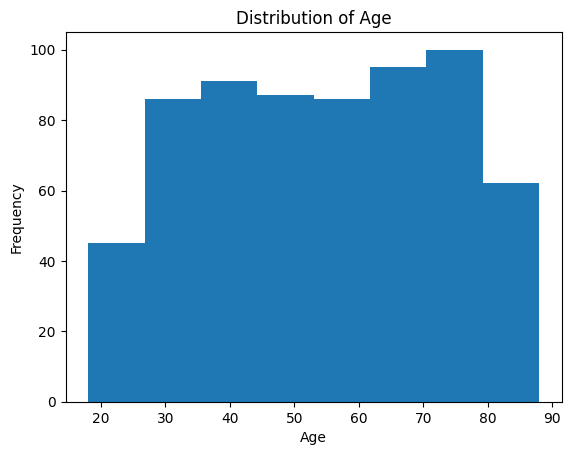

In [39]:
# Looking at age distribution to find the best way to binarize the age variable
plt.hist(y[:,0], bins=8)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

In [40]:
# Age Binning 
    # 0 = 15-25, 1 = 25-35, 2 = 35-55, 3 = 55-65, 4 = 65-75, 5 = 75+
bins = np.array([15, 35, 55, 65, 75])

# Bin the age along the first axis of y
y_binned = np.digitize(y[:,0], bins)

# Use the LabelEncoder to fit and transform the binned ages
le = LabelEncoder()
y_encoded = le.fit_transform(y_binned)

# Recombining the binned age array with participant genders
y_encoded = np.hstack((y_encoded.reshape(-1,1), y[:,1].reshape(-1,1)))

# Check to make sure y_encoded matches y
equal = np.array_equal(y[:, 1], y_encoded[:, 1])

print(f'Genders in y_encoded and y match: {equal}')

Genders in y_encoded and y match: True


# Logistic Regression Classification
Uses a logistic regression classifier to find relationship between age and GM, WM, & CSF

In [44]:
# Make Train and Test Splits
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_encoded,
                                                    stratify=y_encoded,
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True
                                                    )
print(f"Shapes of Train and Test splits: {nl}X_train: {X_train.shape} X_test: {X_test.shape} y_train: {y_train.shape} y_test: {y_test.shape}")

Shapes of Train and Test splits: 
X_train: (521, 3) X_test: (131, 3) y_train: (521, 2) y_test: (131, 2)


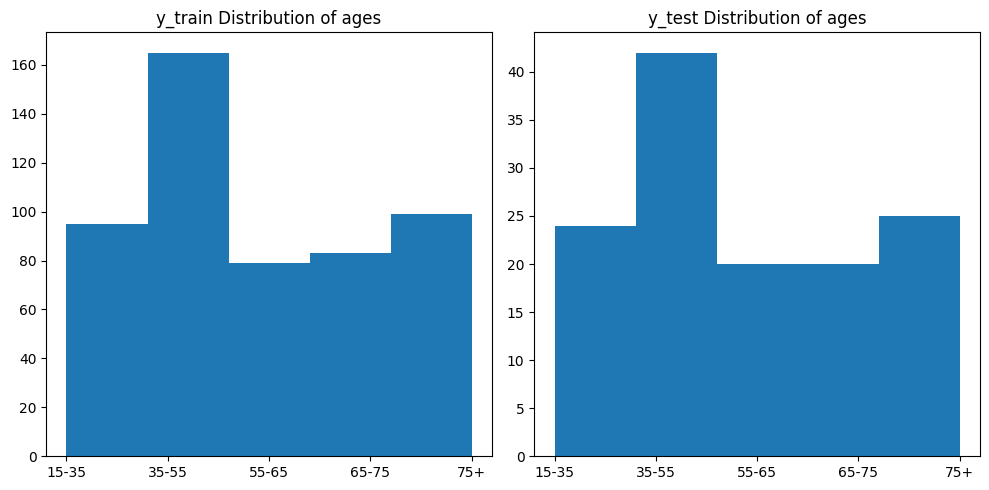

In [55]:
# Visualizing if stratification for Age
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot ages on the first subplot
axs[0].hist(y_train[:,0], bins=5)
axs[0].set_xticks([0, 1, 2, 3, 4])
axs[0].set_xticklabels(['15-35', '35-55', '55-65', '65-75', '75+'])
axs[0].set_title('y_train Distribution of ages')

# Plot ages on the first subplot
axs[1].hist(y_test[:,0], bins=5)
axs[1].set_xticks([0, 1, 2, 3, 4])
axs[1].set_xticklabels(['15-35', '35-55', '55-65', '65-75', '75+'])
axs[1].set_title('y_test Distribution of ages')

plt.tight_layout()
plt.show()

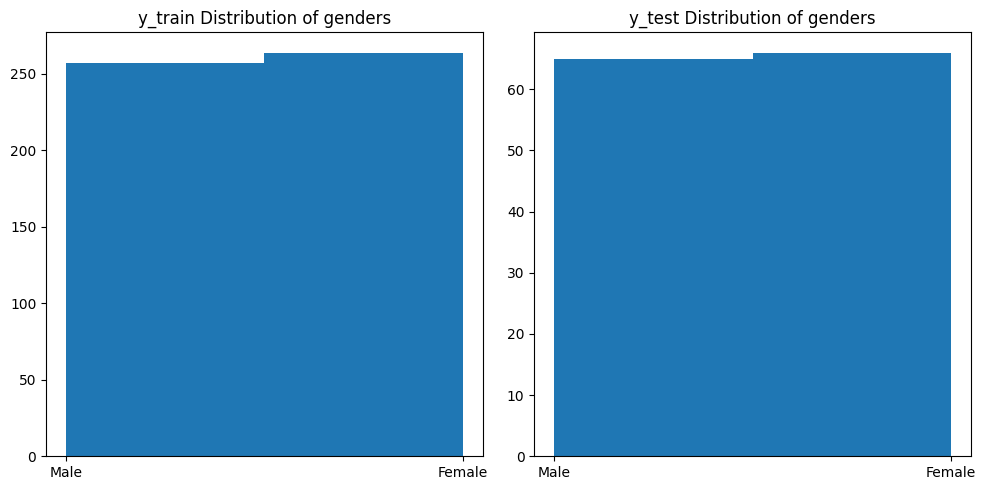

In [56]:
# Visualizing if stratification for gender
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot genders on the second subplot
axs[0].hist(y_train[:,1], bins=2)
axs[0].set_xticks([1, 2], ['Male', 'Female'])
axs[0].set_title('y_train Distribution of genders')

# Plot genders on the second subplot
axs[1].hist(y_test[:,1], bins=2)
axs[1].set_xticks([1, 2], ['Male', 'Female'])
axs[1].set_title('y_test Distribution of genders')

plt.tight_layout()
plt.show()

In [9]:
# Removing gender axis after stratification 
    # We don't want the classifier to train using gender as a feature
y_train = y_train[:,0]
y_test = y_test[:,0]
print(f'New shapes of y_train and y_test: {nl}y_train: {y_train.shape} y_test: {y_test.shape}')

New shapes of y_train and y_test: 
y_train: (521,) y_test: (131,)


In [12]:
# Making scaler, classifier, and cross-validation objects
scaler = StandardScaler()
log_reg = LogisticRegression() # max_iter=10000, tol=0.1, multi_class='auto'
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Hyperparameter grid for GridSearchCV
grid={'logistic__C':np.logspace(-4, 4, 30), 
      'logistic__penalty':['l2','none'],
      'logistic__tol':np.logspace(-4, 4, 20),
      'logistic__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
      }

# Making pipeline object to be used in GridSearchCV
clf = Pipeline([('Scaler', scaler),
                ('logistic', log_reg)                                 
                ])

# making GridSearchCV object
clf_gs = GridSearchCV(clf, 
                      grid, 
                      cv=cv, 
                      scoring='balanced_accuracy', 
                      n_jobs=-1)


# Fit the GridSearchCV object to the training data
print('Searching and Selecting Optimal Hyperparameters...')
clf_gs.fit(X_train, y_train)

print(f'Predicting with Chosen Hyperparameters: {clf_gs.best_params_}')
y_pred = clf_gs.best_estimator_.predict(X_test)

print('Scoring...')        
print(classification_report(y_test, y_pred))


Searching and Selecting Optimal Hyperparameters...
Predicting with Chosen Hyperparameters: {'logistic__C': 0.1082636733874054, 'logistic__penalty': 'none', 'logistic__solver': 'sag', 'logistic__tol': 0.08858667904100823}
Scoring...
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        24
           1       0.61      0.79      0.69        42
           2       0.33      0.10      0.15        20
           3       0.46      0.55      0.50        20
           4       0.83      0.76      0.79        25

    accuracy                           0.63       131
   macro avg       0.59      0.58      0.57       131
weighted avg       0.60      0.63      0.60       131



c:\Users\masci\.conda\envs\neuro\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\masci\.conda\envs\neuro\lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


## Visualizing Results
0 = 15-25, 1 = 25-35, 2 = 35-55, 3 = 55-65, 4 = 65-75, 5 = 75+

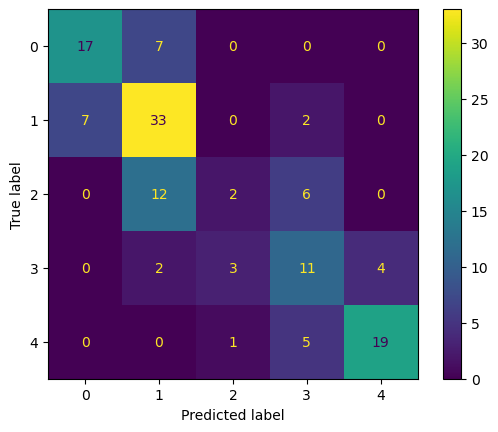

In [14]:
# Confusion Matrix Generation and Visualization
cm = confusion_matrix(y_test, y_pred, labels=clf_gs.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_gs.classes_)
cmd.plot()
plt.show()